In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
print(sys.version)

3.7.6 (default, Jan  8 2020, 19:59:22) 
[GCC 7.3.0]


In [22]:
import math
import os
import pickle
import random
from datetime import datetime

import numpy as np
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from tqdm.notebook import trange, tqdm
from IPython.display import display, Audio

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cuda


In [5]:
torch.manual_seed(0);

## Data processing

In [6]:
DATA_ROOT = "data/pop_pickle"
N_SAMPLES = 909
VOCAB_SIZE = 390
BOS_TOKEN = VOCAB_SIZE - 1

In [7]:
dataset = []
for i in range(N_SAMPLES):
    file_name = str(i + 1).zfill(3) + ".pickle"
    path = os.path.join(DATA_ROOT, file_name)
    with open(path, "rb") as f:
        seq = pickle.load(f)
        seq_tensor = torch.LongTensor(seq)
    dataset.append(seq_tensor)

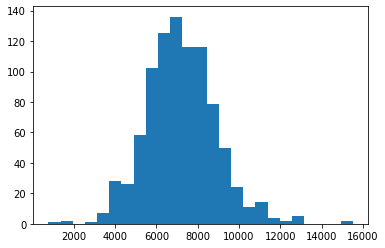

In [8]:
seq_lens = [len(seq) for seq in dataset]

plt.figure()
plt.hist(seq_lens, bins=25)
plt.show()

In [9]:
N_VAL = N_TEST = int(0.05 * 909)
N_TRAIN = 909 - (N_VAL + N_TEST)

train_data = dataset[:N_TRAIN]
val_data = dataset[N_TRAIN:N_TRAIN+N_VAL]
test_data = dataset[N_TRAIN+N_VAL:]

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 819 	 Val: 45 	 Test: 45


In [10]:
def batchify(seq, new_seq_len):
    """
    Convert a sequence into a batch of equal-length sequences,
    and prepend a BOS token at the start of every sequence.
    
    Note that the final sequences will be of length new_seq_len + 1,
    which is desired because the extra token will be trimmed when
    converting the sequence to x and y.
    """
    num_batches = seq.size(0) // new_seq_len
    seq = seq.narrow(dim=0, start=0, length=num_batches*new_seq_len)
    batch = seq.view(num_batches, -1)
    bos = torch.full(size=(num_batches, 1), fill_value=BOS_TOKEN)
    batch = torch.cat([bos, batch], dim=1)    
    return batch


def compute_tokens_lost(seq, new_seq_len):
    """
    Calculate the number of tokens lost when using batchify for
    a given sequence and new_seq_len.
    """
    num_batches = seq.size(0) // new_seq_len
    new_len = num_batches * new_seq_len
    tokens_lost = seq.size(0) - new_len
    return tokens_lost


def compute_total_tokens_lost(dataset, new_seq_len):
    """
    Calculate the number of tokens lost when using batchify for
    a given dataset and new_seq_len.
    """
    return sum(compute_tokens_lost(seq, new_seq_len) for seq in dataset)

In [11]:
SEQ_LEN = 512

train_data = torch.cat([batchify(seq, SEQ_LEN) for seq in train_data])
val_data = torch.cat([batchify(seq, SEQ_LEN) for seq in val_data])
test_data = torch.cat([batchify(seq, SEQ_LEN) for seq in test_data])

print(f"Train: {len(train_data)} \t Val: {len(val_data)} \t Test: {len(test_data)}")

Train: 11113 	 Val: 643 	 Test: 604


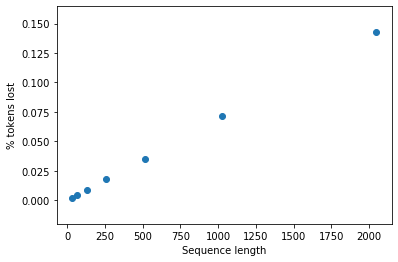

Total tokens: 6560567


In [12]:
seq_lens = np.array([32, 64, 128, 256, 512, 1024, 2048])
tokens_lost = np.array([compute_total_tokens_lost(dataset, seq_len) for seq_len in seq_lens])

total_tokens = sum(seq.size(0) for seq in dataset)
tokens_lost_percent = tokens_lost / total_tokens

plt.figure()
plt.scatter(seq_lens, tokens_lost_percent)
plt.xlabel("Sequence length")
plt.ylabel("% tokens lost")
plt.show()

print(f"Total tokens: {total_tokens}")

## Training the initial model

In [132]:
class MusicRNN(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, rnn_type="lstm", num_layers=1):
        assert rnn_type in ["lstm", "gru"]

        super().__init__()

        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.rnn_type = rnn_type
        self.num_layers = num_layers

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        if rnn_type == "lstm":
            self.rnn = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True) 
        else:
            self.rnn = nn.GRU(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    
        self.hidden_state = None

    def forward(self, x, reset_hidden_state=True):
        x = self.embeddings(x)

        # Forward pass through RNN and FC layer.
        if reset_hidden_state:
            x, _ = self.rnn(x)
        else:
            x, self.hidden_state = self.rnn(x, self.hidden_state)

        # Map to output space.
        x = self.fc(x)

        return x

    def generate_sequence(self, seq_start=None, max_length=1024):
        if not seq_start:
            seq_start = [BOS_TOKEN]
        seq = seq_start.copy()
        with torch.no_grad():
            next_token = self._generate_next_token(
                model,
                next_input=torch.LongTensor(seq).to(device),
                reset_hidden=True,
            )
            while len(seq) <= max_length:
                next_token = self._generate_next_token(
                    model,
                    next_input=torch.LongTensor([next_token]).to(device),
                    reset_hidden=False,
                )
                seq.append(next_token)
        return seq
    
    def _generate_next_token(self, model, next_input, reset_hidden=False, temp=1.0):
        # The model expects a batch input, so we add a fake batch dimension.
        model_input = next_input.unsqueeze(0)
        # Then, we need to remove the fake batch dimension from the output.
        model_output = model(model_input, reset_hidden).squeeze(0)
        next_token_probs = F.softmax(model_output[-1] / temp, dim=0)
        vocab = range(VOCAB_SIZE)
        next_token = np.random.choice(vocab, p=next_token_probs.cpu().numpy())
        return next_token

In [133]:
now = datetime.now().strftime("%Y-%m-%d_%H:%M")

CHECKPOINT_PATH = f"models/ckpt_{now}.pt"

EMBEDDING_DIM = 64
HIDDEN_DIM = 128
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
BATCH_SIZE = 256
CLIPPING_THRESHOLD = 1.0

LOG_EVERY_N = 1
VAL_EVERY_N = 10
SAVE_EVERY_N = 1

In [134]:
train_loader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2,
    collate_fn=lambda x: torch.stack(x),
)
val_loader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2,
    collate_fn=lambda x: torch.stack(x),
)

In [135]:
model = MusicRNN(
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    vocab_size=VOCAB_SIZE,
    rnn_type="lstm",
    num_layers=1,
).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [136]:
print(model)

MusicRNN(
  (embeddings): Embedding(390, 64)
  (rnn): LSTM(64, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=390, bias=True)
)


In [137]:
def validate(model, data_loader):
    model.eval()
    with torch.no_grad():
        total_loss = 0.0
        for batch in data_loader:
            batch = batch.to(device)
            x = batch[:, :-1]
            y = batch[:, 1:]
            y_hat = model(x)
            y_hat = y_hat.transpose(1, 2)
            loss = loss_function(y_hat, y)
            total_loss += loss.item()
        ppl = math.exp(total_loss / len(data_loader))
        return ppl

In [138]:
writer = SummaryWriter(f"runs/lstm_exp_{now}")

In [51]:
for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_loss = 0.0
    for batch in tqdm(train_loader):
        # Move to GPU if available.
        batch = batch.to(device)

        # Reset gradients.
        model.zero_grad()

        # Prepare inputs and targets.
        x = batch[:, :-1]
        y = batch[:, 1:]
                
        # Forward prop.
        y_hat = model(x)
        
        # Swap token dim and output dim.
        y_hat = y_hat.transpose(1, 2)
        
        # Compute loss.
        loss = loss_function(y_hat, y)
        total_loss += loss.item()

        # Back prop.
        loss.backward()
        
        # Clip gradients.
        # clip_grad_norm_(model.parameters(), CLIPPING_THRESHOLD)
        
        # Update parameters.
        optimizer.step()
        
    if epoch % LOG_EVERY_N == 0:
        avg_loss = total_loss / len(train_loader)  # per token loss
        writer.add_scalar("train_loss", avg_loss, global_step=epoch)
        
        train_ppl = math.exp(avg_loss)
        writer.add_scalar("train_ppl", train_ppl, global_step=epoch)

    if epoch % VAL_EVERY_N == 0:
        val_ppl = validate(model, val_loader)
        writer.add_scalar("val_ppl", val_ppl, global_step=epoch)

    if epoch % SAVE_EVERY_N == 0:
        state_checkpoint = {
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
        }
        torch.save(state_checkpoint, CHECKPOINT_PATH)

KeyboardInterrupt: 

## Generating music